In [17]:
from helper import *

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

No GPU available


In [19]:
data = pd.read_csv("data.csv")
print(data.shape)

(5572, 7480)


In [20]:
X = data["text_clean"]
X = pd.Series(map(str, X))
y = data["y"]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5572,) (5572,)
(4457,) (4457,)
(1115,) (1115,)


In [21]:
MAX_NUM_WORDS = 2000
MAX_SEQUENCE_LENGTH = 100
X_sequence_train , tok = tokenize_text(X_train, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
X_sequence_test = pad_sequences(tok.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)
print(X_sequence_train.shape, X_sequence_test.shape)

(4457, 100) (1115, 100)


In [22]:
def make_model(name, 
               embedding_dim=128, 
               lstm_units=128, 
               dense_units=64,
               dropout_rate=0.2,
            ):
    model = Sequential(name=name)
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=embedding_dim))
    model.add(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
    # model.summary()
    return model
        
param_grid = {
        'embedding_dim': [50, 100],
        'lstm_units': [24,32,48],
        'dense_units': [32,64,96],
        'dropout_rate': [0.1,0.2, 0.4],
    }   


In [23]:
# r = grid_search(param_grid, make_model, X_sequence_train , y_train , X_sequence_test , y_test)
r = grid_search(param_grid, make_model, X_sequence_train , y_train , X_sequence_test , y_test)

Grid size: 54
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8417 - loss: 0.5611 - val_accuracy: 0.8565 - val_loss: 0.3105
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8867 - loss: 0.2473 - val_accuracy: 0.9439 - val_loss: 0.2131
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9667 - loss: 0.1447 - val_accuracy: 0.9596 - val_loss: 0.1343
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9851 - loss: 0.0723 - val_accuracy: 0.9686 - val_loss: 0.0956
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9922 - loss: 0.0354 - val_accuracy: 0.9709 - val_loss: 0.0825
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9965 - loss: 0.0195 - val_accuracy: 0.9686 - val_loss: 0.0867
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9978 - loss: 0.0140 - val_accuracy: 0.9709 - val_loss: 0.0958
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9977 - loss: 0.0103 - val_accura

In [24]:
from pprint import pprint

r.sort(key=lambda x: x[2]["classification_report"]["weighted avg"]['f1-score'], reverse=True)
pprint([ (params , metrics["classification_report"]["weighted avg"]['f1-score']) for model, params, metrics in r])

[({'dense_units': 64,
   'dropout_rate': 0.2,
   'embedding_dim': 100,
   'lstm_units': 32,
   'name': 'Model27'},
  0.9890467041975126),
 ({'dense_units': 32,
   'dropout_rate': 0.2,
   'embedding_dim': 100,
   'lstm_units': 24,
   'name': 'Model19'},
  0.9881157527912083),
 ({'dense_units': 96,
   'dropout_rate': 0.2,
   'embedding_dim': 100,
   'lstm_units': 32,
   'name': 'Model33'},
  0.9872211548970979),
 ({'dense_units': 96,
   'dropout_rate': 0.4,
   'embedding_dim': 100,
   'lstm_units': 24,
   'name': 'Model49'},
  0.9871818423138803),
 ({'dense_units': 96,
   'dropout_rate': 0.1,
   'embedding_dim': 50,
   'lstm_units': 32,
   'name': 'Model14'},
  0.986329180929112),
 ({'dense_units': 96,
   'dropout_rate': 0.1,
   'embedding_dim': 50,
   'lstm_units': 48,
   'name': 'Model16'},
  0.986329180929112),
 ({'dense_units': 64,
   'dropout_rate': 0.2,
   'embedding_dim': 50,
   'lstm_units': 32,
   'name': 'Model26'},
  0.986329180929112),
 ({'dense_units': 96,
   'dropout_rate':

In [25]:
# save models in directory models
# for model, params, metrics in r:
#     model.save(f"models/{model.name}.keras")

In [26]:
X2 = data["text"]
X2 = pd.Series(map(str, X2))
y = data["y"]
print(X2.shape, y.shape)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=TEST_SPLIT, random_state=42)
print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

(5572,) (5572,)
(4457,) (4457,)
(1115,) (1115,)


In [27]:
MAX_NUM_WORDS = 2000
MAX_SEQUENCE_LENGTH = 100
X2_sequence_train , tok2 = tokenize_text(X2_train, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
X2_sequence_test = pad_sequences(tok2.texts_to_sequences(X2_test), maxlen=MAX_SEQUENCE_LENGTH)
print(X2_sequence_train.shape, X2_sequence_test.shape)

(4457, 100) (1115, 100)


In [28]:
param_grid = {
        'embedding_dim': [50, 100],
        'lstm_units': [24,32,48],
        'dense_units': [32,64,96],
        'dropout_rate': [0.1,0.2, 0.4],
    }  
# r2 = grid_search(param_grid, make_model, X2_sequence_train , y2_train , X2_sequence_test , y2_test)
r2 = grid_search(param_grid, make_model, X2_sequence_train , y2_train , X2_sequence_test , y2_test)

Grid size: 54
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8451 - loss: 0.5559 - val_accuracy: 0.8565 - val_loss: 0.2631
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9098 - loss: 0.2169 - val_accuracy: 0.9574 - val_loss: 0.1683
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9751 - loss: 0.1060 - val_accuracy: 0.9664 - val_loss: 0.1128
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9868 - loss: 0.0527 - val_accuracy: 0.9709 - val_loss: 0.0877
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9919 - loss: 0.0329 - val_accuracy: 0.9709 - val_loss: 0.0836
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9949 - loss: 0.0237 - val_accuracy: 0.9709 - val_loss: 0.0901
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9965 - loss: 0.0178 - val_accuracy: 0.9709 - val_loss: 0.0873
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9970 - loss: 0.0115 - val_accura

In [29]:
from pprint import pprint

r2.sort(key=lambda x: x[2]["classification_report"]["weighted avg"]['f1-score'], reverse=True)
pprint([ (params , metrics["classification_report"]["weighted avg"]['f1-score']) for model, params, metrics in r2])

[({'dense_units': 96,
   'dropout_rate': 0.1,
   'embedding_dim': 50,
   'lstm_units': 48,
   'name': 'Model16'},
  0.9845064050529936),
 ({'dense_units': 32,
   'dropout_rate': 0.2,
   'embedding_dim': 50,
   'lstm_units': 32,
   'name': 'Model20'},
  0.9845064050529936),
 ({'dense_units': 64,
   'dropout_rate': 0.2,
   'embedding_dim': 50,
   'lstm_units': 48,
   'name': 'Model28'},
  0.9845064050529936),
 ({'dense_units': 32,
   'dropout_rate': 0.1,
   'embedding_dim': 100,
   'lstm_units': 24,
   'name': 'Model1'},
  0.9836686783500632),
 ({'dense_units': 32,
   'dropout_rate': 0.1,
   'embedding_dim': 50,
   'lstm_units': 32,
   'name': 'Model2'},
  0.9836686783500632),
 ({'dense_units': 32,
   'dropout_rate': 0.1,
   'embedding_dim': 100,
   'lstm_units': 48,
   'name': 'Model5'},
  0.9836686783500632),
 ({'dense_units': 64,
   'dropout_rate': 0.1,
   'embedding_dim': 100,
   'lstm_units': 24,
   'name': 'Model7'},
  0.9836686783500632),
 ({'dense_units': 64,
   'dropout_rate': 0

In [30]:
# for model, params, metrics in r2:
#     model.save(f"models2/{model.name}.keras")

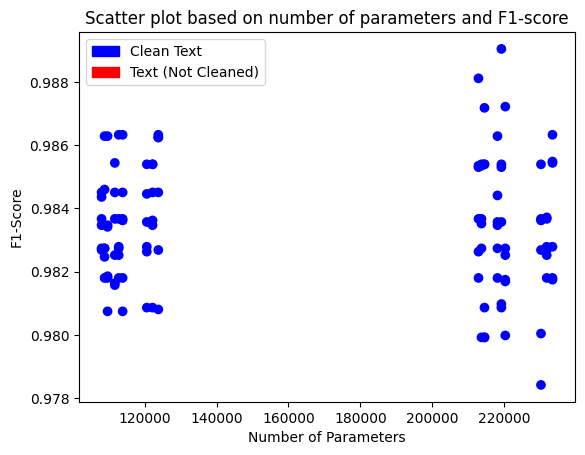

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Example data
rx = [model.count_params() for model, _, _ in r]
r2x = [model.count_params() for model, _, _ in r2]
ry = [metrics["classification_report"]["weighted avg"]['f1-score'] for _, _, metrics in r]
r2y = [metrics["classification_report"]["weighted avg"]['f1-score'] for _, _, metrics in r2]

# Combine the data
datax = rx + r2x
datay = ry + r2y

# Create a color list based on the array
colors = ['blue' if value in rx else 'red' for value in datax]

# Plot the data
plt.scatter(datax, datay, c=colors)

# Create legend handles
blue_patch = mpatches.Patch(color='blue', label='Clean Text')
red_patch = mpatches.Patch(color='red', label='Text (Not Cleaned)')

# Add legend to the plot
plt.legend(handles=[blue_patch, red_patch])

# Add labels and title
plt.xlabel('Number of Parameters')
plt.ylabel('F1-Score')
plt.title('Scatter plot based on number of parameters and F1-score')

# Show the plot
plt.show()

In [32]:
print(r)
res = model_pass(r[0][1],make_model, X_sequence_train , y_train , X_sequence_test , y_test)

[(<Sequential name=Model27, built=True>, {'embedding_dim': 100, 'lstm_units': 32, 'dense_units': 64, 'dropout_rate': 0.2, 'name': 'Model27'}, {'confusion_matrix': array([[965,   0],
       [ 12, 138]], dtype=int64), 'classification_report': {'0': {'precision': 0.9877175025588536, 'recall': 1.0, 'f1-score': 0.9938208032955715, 'support': 965.0}, '1': {'precision': 1.0, 'recall': 0.92, 'f1-score': 0.9583333333333334, 'support': 150.0}, 'accuracy': 0.989237668161435, 'macro avg': {'precision': 0.9938587512794268, 'recall': 0.96, 'f1-score': 0.9760770683144524, 'support': 1115.0}, 'weighted avg': {'precision': 0.9893698564747029, 'recall': 0.989237668161435, 'f1-score': 0.9890467041975126, 'support': 1115.0}}, 'roc_auc': 0.96, 'fpr': array([0., 0., 1.]), 'tpr': array([0.  , 0.92, 1.  ]), 'history': <keras.src.callbacks.history.History object at 0x0000018ABF6D4F50>}), (<Sequential name=Model19, built=True>, {'embedding_dim': 100, 'lstm_units': 24, 'dense_units': 32, 'dropout_rate': 0.2, 'na

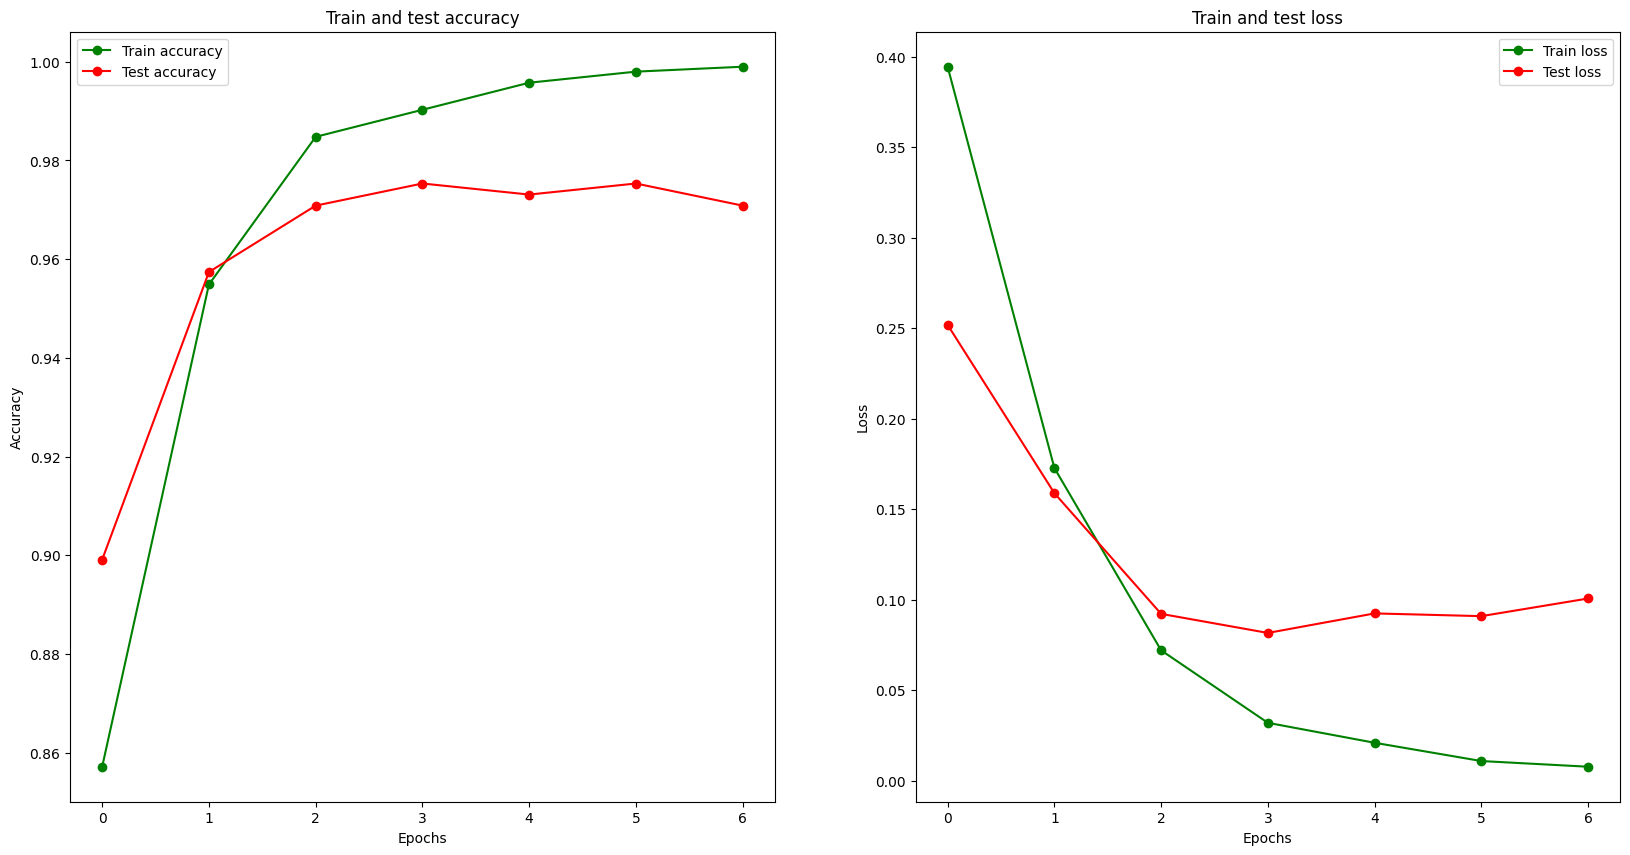

In [33]:
epochs = [i for i in range(7)]
history = res[1]["history"]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

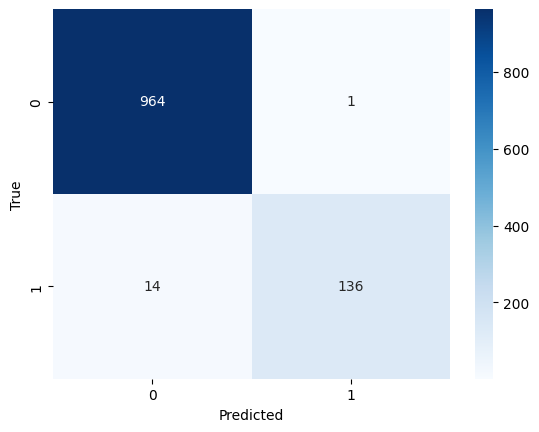

In [34]:
cm = res[1]["confusion_matrix"]

import seaborn as sns
# plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [60]:
# show examples of misclassifcation
y_pred = np.round(res[0].predict(X_sequence_test))

misclassified = np.where(y_pred != np.array(y_test).reshape(1115,1))[0]
print(misclassified.shape)
print("Misclassified examples:")
for idx in misclassified:
    print(f"Example {idx}: {X2_test.iloc[idx]} (Predicted: {y_pred[idx]}, Actual: {y_test.iloc[idx]})")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(15,)
Misclassified examples:
Example 0: Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens (Predicted: [1.], Actual: 0)
Example 195: Loans for any purpose even if you have Bad Credit! Tenants Welcome. Call NoWorriesLoans.com on 08717111821 (Predicted: [0.], Actual: 1)
Example 225: ringtoneking 84484 (Predicted: [0.], Actual: 1)
Example 397: Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA (Predicted: [0.], Actual: 1)
Example 448: Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123 (Predicted: [0.], Actual: 1)
Example 522: Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy? (Predicted: [0.], Actual: 1)
Example 558: LookAtMe!